# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21
import torch

from fastai.distributed import *
from fastai.text.models.transformer import *

import numpy as np

import sys
sys.path.insert(0, '../../src')
from fastai_data import *
from lmnp_transformer import *
from encode_data import *

In [3]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [4]:
source_dir = 'midi_encode/np/shortdur'
path = Path('../../data/midi/v9/')/source_dir
out_path = Path('../../data/generated/')

## Prediction code

In [5]:
bs=16
bptt=256

In [6]:
transpose_tfm = partial(rand_transpose, enc_offset=ENC_OFFSET, rand_range=(0,12))

In [7]:
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/hook', train_tfms=[transpose_tfm])

In [8]:
VOCAB_SZ = create_vocab_sizes(path/'tmp/all')
N_COMPS = len(VOCAB_SZ)
N_EMBS = 128
EMB_IDXS = range(N_COMPS)
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
EMB_MAP

[(0, 130, 128), (1, 132, 128)]

In [9]:
idx2embidx = { i:EMB_MAP[i] for i in range(N_COMPS) }
total_embs = sum([v[-1] for k,v in idx2embidx.items()])

In [10]:
config = tfmerXL_lm_config
config['emb_map'] = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
config['idx_map'] = idx2embidx
config['loss_weights'] = [1,1] # note,duration
config['pad_idx'] = PADDING_IDX+ENC_OFFSET
config['bos_idx'] = VALTBOS+ENC_OFFSET
config['mask_type'] = MaskType.RandomWindow
config['act'] = Activation.ReLU

config['d_model'] = total_embs
config['mem_len'] = 512

config['resid_p'] = 0.1
config['attn_p'] = 0.1 # attention dropout
config['ff_p'] = 0.1
config['embed_p'] = 0.1 # embedding dropout
config['output_p'] = 0.1 # decoder dropout (before final linear layer)
config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'mask_type': <MaskType.RandomWindow: 3>}

In [11]:
learn = language_model_learner(data, config, clip=0.25)

In [12]:
x,y = data.one_batch(cpu=False)

In [13]:
models = get_files(path/'models/hook', recurse=True); models

[PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20_best.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20_best.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30_best.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_gelu_1_ep50.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_gelu_1_ep50_best.pth'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30.pth')]

In [14]:
# load_path = Path('data/midi/v9/midi_encode/np/shortdur/models/pop/v9_2_epoch30_best.pth')
load_path = Path('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30_best.pth')
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)

### From batch

In [15]:
xb,yb = learn.data.one_batch(cpu=False)

## Flask App

In [16]:
from flask import Flask, Response

app = Flask(__name__)

@app.route('/hello/', methods=['GET', 'POST'])
def hello_world():
    return 'Hello, World!'

In [17]:
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)
# Loading from specific file
keywords = 'country road'.split(' ')
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')]

In [18]:
import pandas as pd

In [19]:

def song_csv():
    if not (path/'midi_encode.pkl').exists():
        df = pd.read_csv(path/'midi_encode.csv')
        df.to_pickle(path/'midi_encode.pkl')
    else:
        df = pd.read_pickle(path/'midi_encode.pkl')

    df = df.loc[df[source_dir].notna()] # make sure it exists
    df = df.loc[df.source == 'hooktheory'] # hooktheory only
    # df.loc[df.artist.str.contains('garrix')]
    files = song_csv()[source_dir].values.tolist()
    return df, files


In [20]:
def search(keywords='country road'):
    keywords = keywords.split(' ')
    def contains_keywords(f): return all([k in str(f) for k in keywords])
    search = [f for f in files if contains_keywords(f)]
    return search

In [21]:
@app.route('/songs/list')
def song_list():
    # get song name and artist from csv
    result = dict({
        'list': files
    })

@app.route('/songs/search')
def song_search():
    keywords = request.args.get('keywords', '')
    files = search(keywords)
    result = dict({
        'list': files
    })

In [22]:
def stream2midifile(stream, file_name):
#     import uuid
#     file_name = str(uuid.uuid4())
    return stream.write("midi", out_path/f"{file_name}.mid")
    
def stream2scoreimg(stream, file_name):
    return stream.write('musicxml', out_path/f"{file_name}.xml")

import uuid

def stream2comps(stream, file_name=None):
    mf = stream2midifile(stream, file_name)
    lil = stream2scoreimg(stream, file_name)
    return mf, lil

In [23]:
@app.route('/midi/score')
def midi_score():
    'Show piano score image'
    pass

@app.route('/midi/file')
def midi_file():
    'Return npenc to midi'
    pass

@app.route('/midi/save')
def midi_save():
    'Save sequence from key-editor to midi'
    pass

In [24]:
def generate_predictions(midi_file=None, np_file=None, seed_len=60, n_words=340, 
                         temperatures=(1.5,0.9), min_ps=(1/128,0.0), **kwargs):
    file = np_file
    song_np = np.load(file)
    seed_np = np.load(file)[:seed_len]
    xb = torch.tensor(seed_np)[None]
    pred, seed = learn.predict(xb, n_words=n_words, temperatures=temperatures, min_ps=min_ps)
    full_output = np.concatenate((seed,pred), axis=0)
    full_stream = npenc2stream(full_output)
#     return full_stream
    songid = str(uuid.uuid4())
    midi, score = stream2comps(full_stream, songid)
    return midi, score, pred_id

In [25]:
@app.route('/predict')
def predict():
    midi, score, pred_id = generate_predictions(**request.args)
    
    result = dict({
        'midi': midi,
        'score': score,
        'pred_id':  songid
    })
    return jsonify(result)

In [26]:
test_file = '../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'



In [27]:
stream = generate_predictions(np_file=test_file)

Predicted BOS token. Returning prediction...


In [28]:
stream

(PosixPath('../../data/generated/6bac65c4-1e35-4915-b3e7-98b3df85f427.mid'),
 PosixPath('/home/ubuntu/midi_generator/data/generated/6bac65c4-1e35-4915-b3e7-98b3df85f427.xml'),
 '6bac65c4-1e35-4915-b3e7-98b3df85f427')

Valid formats include (but are not limited to)::
    musicxml
    text
    midi
    lily (or lilypond)
    lily.png
    lily.pdf
    lily.svg
    braille
    vexflow
    musicxml.png

In [41]:
stream.write('musicxml.png', '/tmp/abc.xml')

'/tmp/abc-1.png'

In [43]:
from PIL import Image

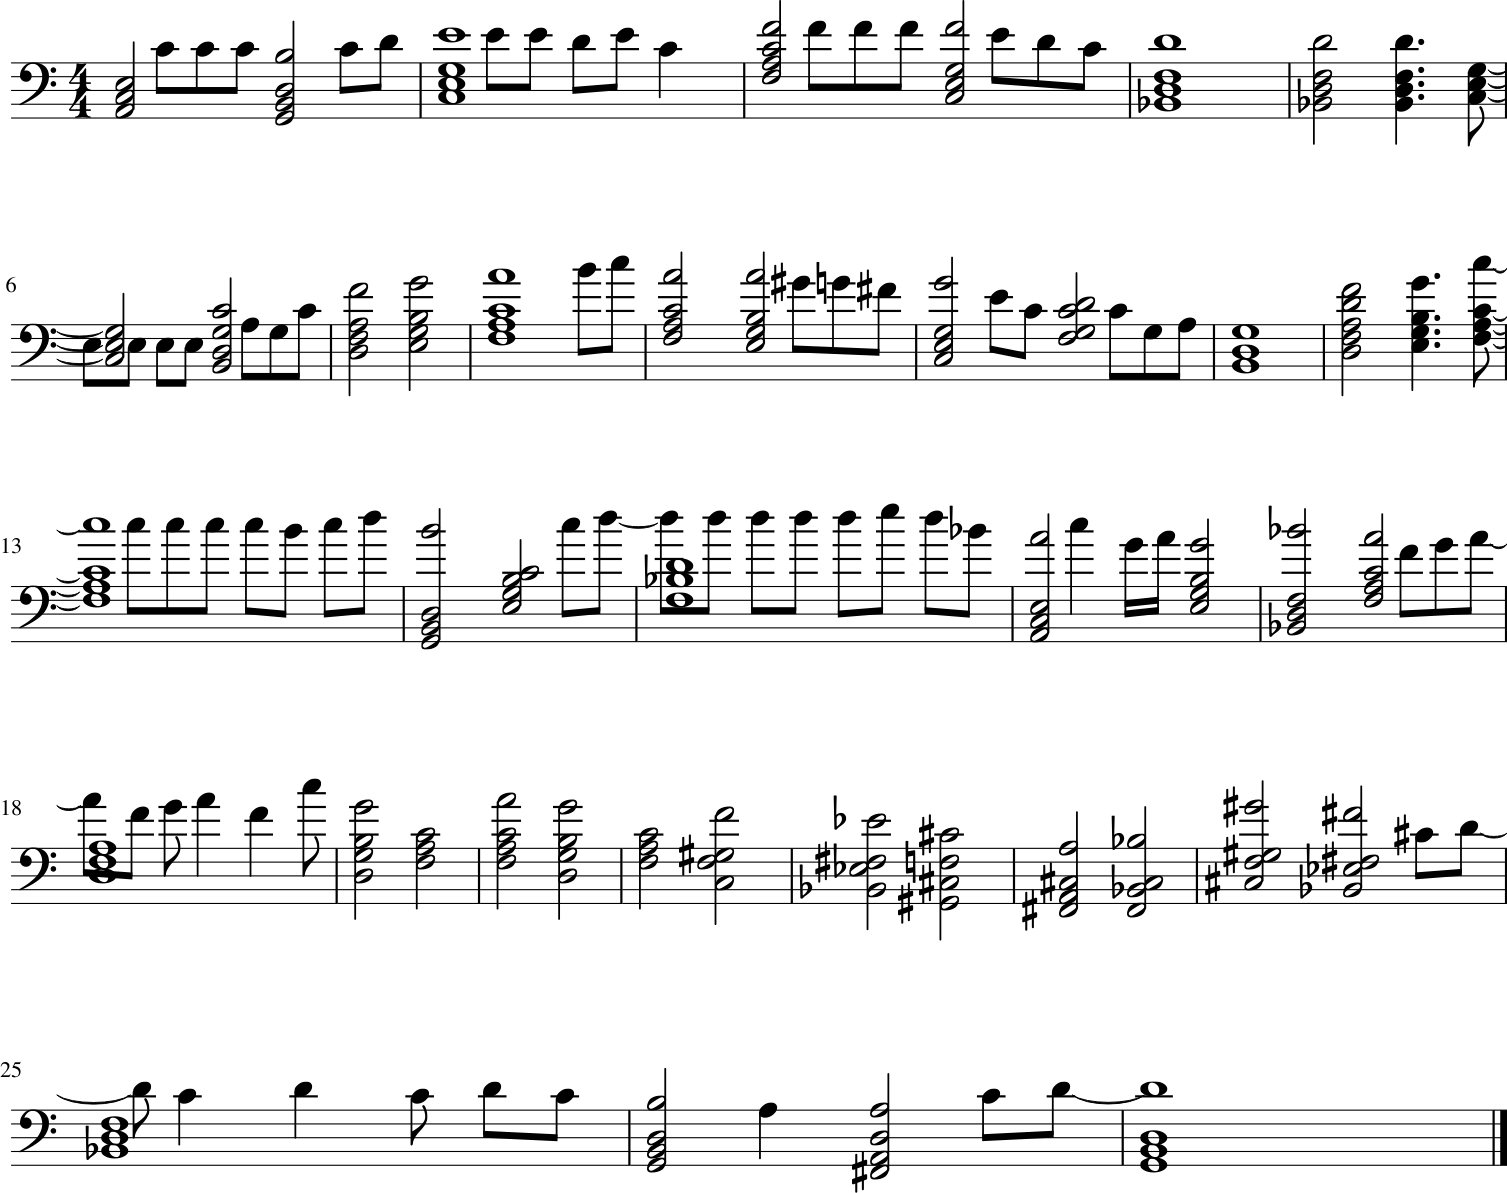

In [46]:
Image.open('/tmp/abc-1.png')

In [37]:
stream.show('musicxml.png')

SubConverterException: Cannot find a valid application path for format png. Specify this in your Environment by calling environment.set('graphicsPath', '/path/to/application')

In [ ]:
@app.route('/health')
def health_check():
    return Response("", status = 200)

# if __name__ == '__main__':
#     app.run(debug=True,host='0.0.0.0')

In [19]:
from werkzeug.serving import run_simple
run_simple('localhost', 6006, app)

 * Running on http://localhost:6006/ (Press CTRL+C to quit)
127.0.0.1 - - [22/Mar/2019 12:30:47] "POST /hello HTTP/1.1" 301 -
127.0.0.1 - - [22/Mar/2019 12:30:47] "GET /hello/ HTTP/1.1" 200 -
127.0.0.1 - - [22/Mar/2019 12:32:27] "POST /predict HTTP/1.1" 405 -
